# Homework 1.2


## Mihai Croicu
#### 2019-07-29

In [2]:
library(foreign)
library(tidyverse)
library(MASS)
library(arm) #Don't forget to install if you haven't loaded this package before
library(MCMCpack)
library(foreign)
library(MCMCglmm)
library(BMS)

set.seed(1)

# Remember I have loaded both dplyr and MASS, 
# so select doesn't work without specifying its namespace

In [3]:
jws <- read.dta("https://www.dropbox.com/s/d8wftrzy8gyh6zc/jws.dta?dl=1")

## Prerequisite work

I want to understand the data, get some descriptives and see that everything in the data is working as it should. My plan is as follows for this section

1. Some data exploration and descriptives
2. Running a MLE to see what that does, and anchor the Bayesian results in my old frequentist knowledge
3. Running a Bayesian regression with the default priors, just to see that everything is correctly installed and works well (MLE and Bayesian with uniform priors should produce the same results)

In [4]:
# Some data inspection
head(jws)

usid,docket,caseid,term,lawyernumber,grade,prevexp1_log,sghimself,sg_asst,us_party_notsg,⋯,dcprac_notus,lawprof,amicus_notsg,clerk,ideodiff_mq_1,appellate,complexity,certmwc,casereargued,certunan
4000074,10,1,1970,21,0.4622682,0.000000,0,0,0,⋯,0,0,0,0,1.898581,1,-0.152566,0,0,0
4000074,10,1,1970,444,0.4622682,0.000000,0,0,0,⋯,1,0,0,1,1.898581,1,-0.152566,0,0,0
4000074,10,1,1970,21,0.4622682,0.000000,0,0,0,⋯,0,0,0,0,1.898581,1,-0.152566,0,0,0
4010402,1066,2,1970,756,0.7960877,4.077538,1,0,0,⋯,0,0,0,0,1.898581,0,0.609800,1,0,0
4010402,1066,2,1970,444,0.4622682,0.000000,0,0,0,⋯,1,0,0,1,-1.898581,1,0.609800,1,0,0
4010402,1066,2,1970,461,0.7960877,0.000000,0,0,0,⋯,0,0,0,0,1.898581,0,0.609800,1,0,0


[1] "Rows:   Columns: "

'data.frame':	1118 obs. of  21 variables:
 $ usid             : num  4000074 4000074 4000074 4010402 4010402 ...
 $ docket           : chr  "10" "10" "10" "1066" ...
 $ caseid           : num  1 1 1 2 2 2 3 3 4 6 ...
 $ term             : num  1970 1970 1970 1970 1970 1970 1970 1970 1970 1970 ...
 $ lawyernumber     : num  21 444 21 756 444 461 171 39 108 413 ...
 $ grade            : num  0.462 0.462 0.462 0.796 0.462 ...
 $ prevexp1_log     : num  0 0 0 4.08 0 ...
 $ sghimself        : num  0 0 0 1 0 0 0 0 0 0 ...
 $ sg_asst          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ us_party_notsg   : num  0 0 0 0 0 0 0 0 1 0 ...
 $ elite_lawschool_1: num  0 1 0 1 1 0 1 1 0 0 ...
 $ dcprac_notus     : num  0 1 0 0 1 0 0 1 0 0 ...
 $ lawprof          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ amicus_notsg     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ clerk            : num  0 1 0 0 1 0 0 0 0 0 ...
 $ ideodiff_mq_1    : num  1.9 1.9 1.9 1.9 -1.9 ...
 $ appellate        : num  1 1 1 0 1 0 1 0 1 0 ...
 $ complexity     

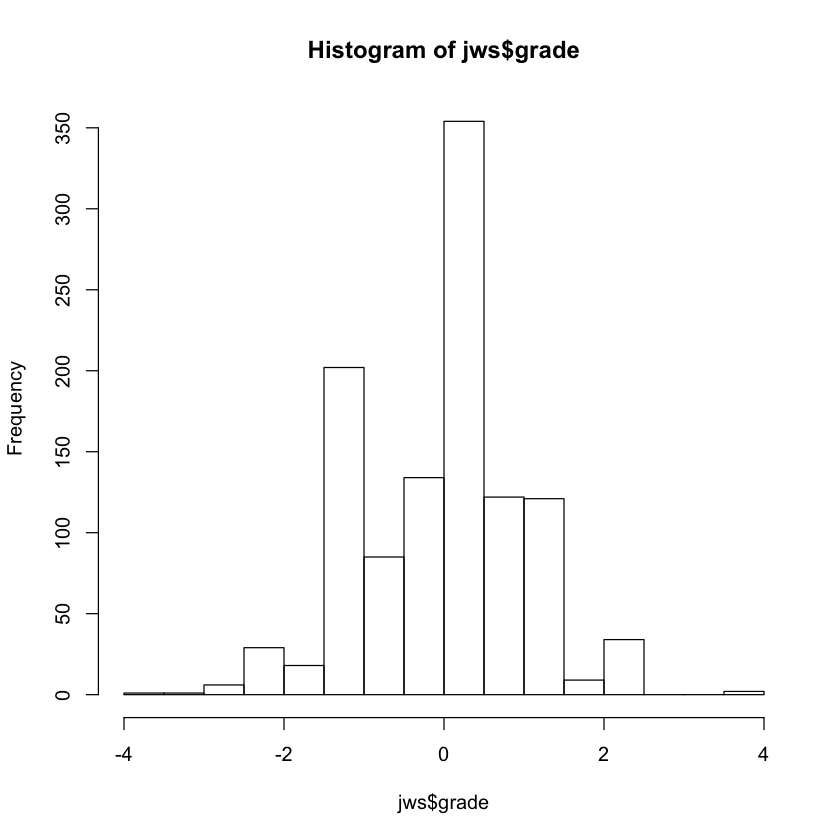

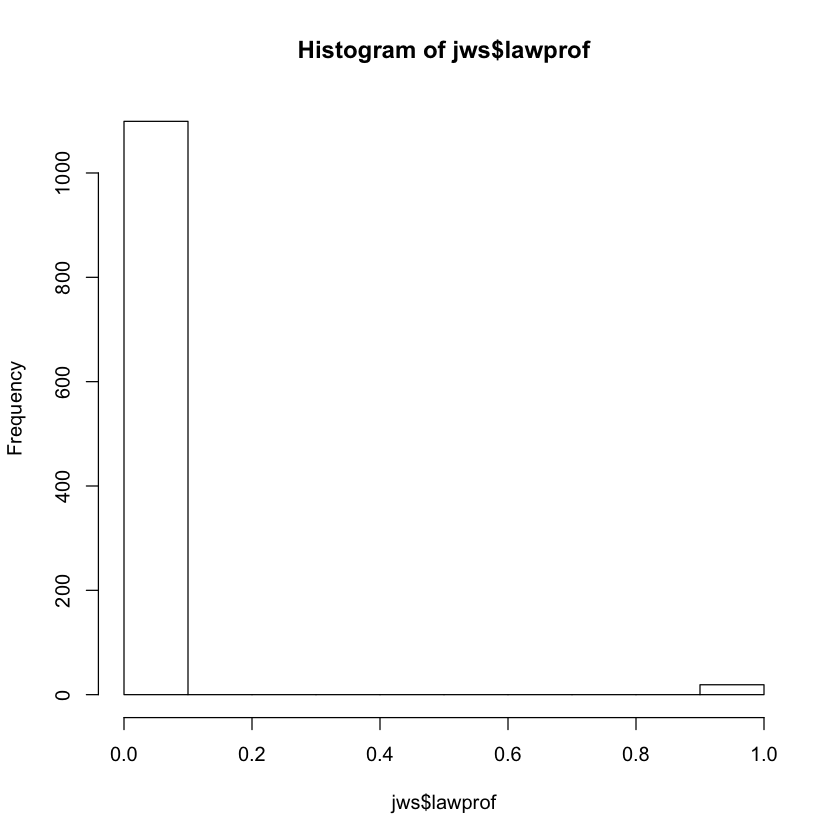

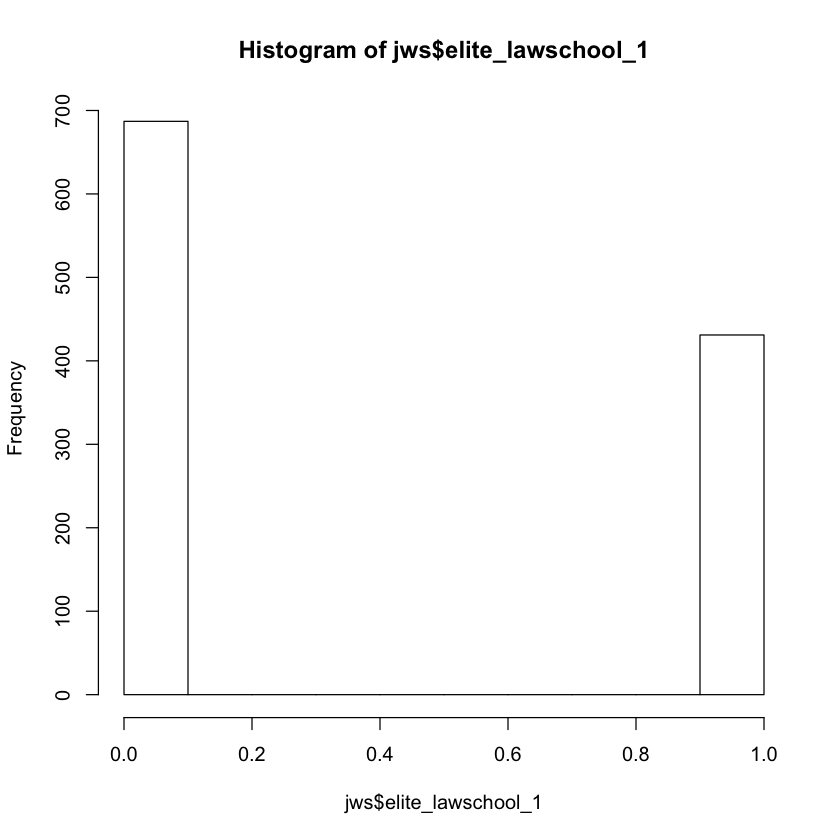

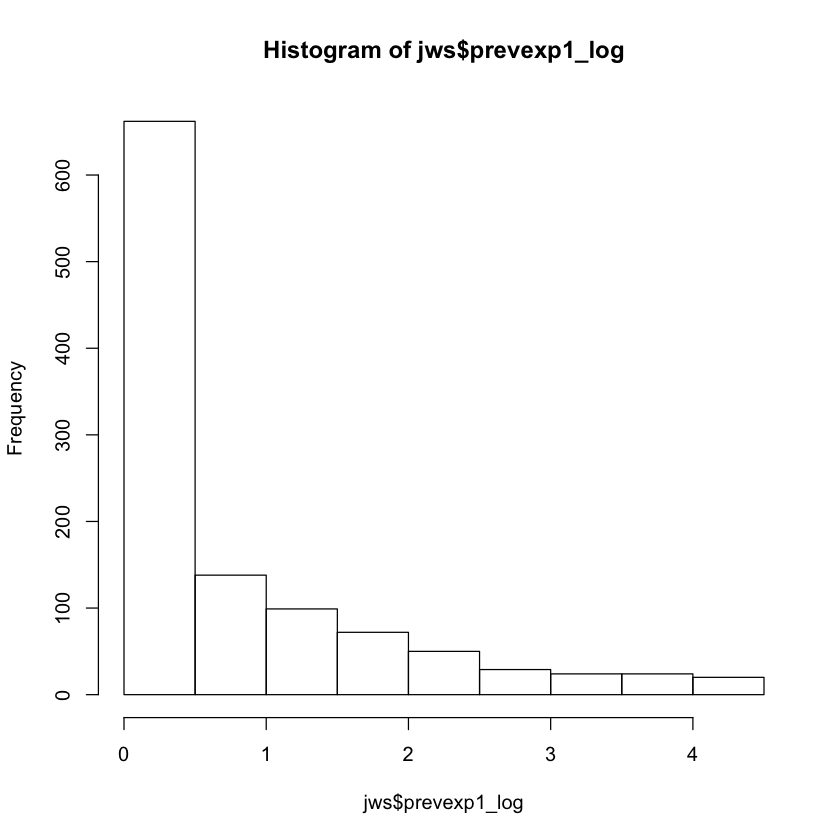

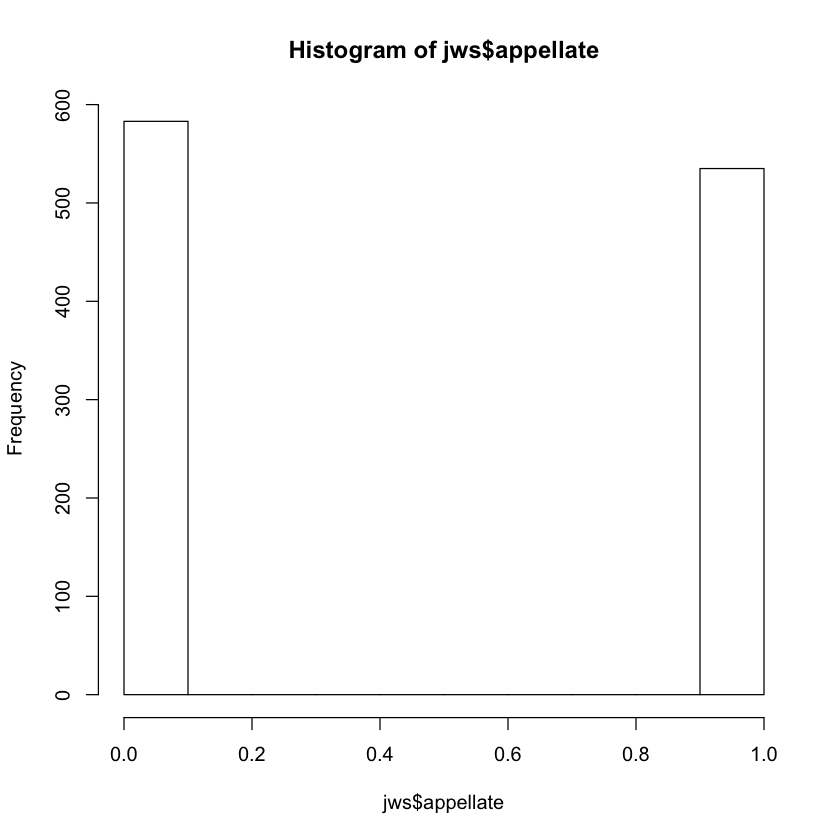

In [5]:
#Some simple descriptives
paste("Rows:",ncol(data), " Columns:",ncol(data))
str(jws)

#Some simple descriptives:
hist(jws$grade)
hist(jws$lawprof)
hist(jws$elite_lawschool_1)
hist(jws$prevexp1_log)
hist(jws$appellate)



In [6]:
# Since we are going to use the formula many times, let's keep both the components and the formula together:
right_hand = c('prevexp1_log','sghimself','sg_asst','us_party_notsg','elite_lawschool_1','dcprac_notus','lawprof','amicus_notsg','clerk','ideodiff_mq_1','appellate')
left_hand = c('grade')
jws_formula = as.formula(paste('grade ~',paste(right_hand,collapse='+')))
print(jws_formula)

grade ~ prevexp1_log + sghimself + sg_asst + us_party_notsg + 
    elite_lawschool_1 + dcprac_notus + lawprof + amicus_notsg + 
    clerk + ideodiff_mq_1 + appellate


In [7]:
## This is how we do it in the MLE world we've left. I'm doing this to check that everything is right.
lm_mle <- lm(jws_formula, data = jws)
summary(lm_mle)
confint(lm_mle)


Call:
lm(formula = jws_formula, data = jws)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6430 -0.6352  0.0044  0.5872  4.2631 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -0.31682    0.04815  -6.580 7.26e-11 ***
prevexp1_log       0.26239    0.03375   7.775 1.72e-14 ***
sghimself          0.36987    0.19937   1.855  0.06384 .  
sg_asst            0.10172    0.10110   1.006  0.31455    
us_party_notsg     0.16513    0.08757   1.886  0.05959 .  
elite_lawschool_1  0.20906    0.06067   3.446  0.00059 ***
dcprac_notus       0.40060    0.09310   4.303 1.83e-05 ***
lawprof            0.21726    0.20837   1.043  0.29732    
amicus_notsg      -0.16263    0.23572  -0.690  0.49038    
clerk              0.27629    0.11432   2.417  0.01582 *  
ideodiff_mq_1      0.05144    0.02552   2.015  0.04409 *  
appellate         -0.12099    0.05531  -2.187  0.02892 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual st

,2.5 %,97.5 %
(Intercept),-0.411301626,-0.22234239
prevexp1_log,0.196170489,0.32860285
sghimself,-0.021319409,0.76106173
sg_asst,-0.096645102,0.30009329
us_party_notsg,-0.006687942,0.33695698
elite_lawschool_1,0.090024858,0.32809097
dcprac_notus,0.217932129,0.58327283
lawprof,-0.191577993,0.62609902
amicus_notsg,-0.625150870,0.29988519
clerk,0.051978951,0.50060370


### This is not the bayesian replication for task 1.1. I want this to test that I've installed everything right, and to have a baseline to compare and understand what my results do.

In [8]:
# First, I want to be convinced that everything is installed properly and works as expected
# So, let's run this with the default priors, which should produce similar results as MLE estimates

lm_mcmc_0 <- MCMCglmm(grade ~ prevexp1_log + sghimself + sg_asst + us_party_notsg + elite_lawschool_1 + dcprac_notus + lawprof + amicus_notsg + clerk + ideodiff_mq_1 + appellate, data = jws)
summary(lm_mcmc_0)

# Looks ok. Why does it put stars on the summary?


                       MCMC iteration = 0

                       MCMC iteration = 1000

                       MCMC iteration = 2000

                       MCMC iteration = 3000

                       MCMC iteration = 4000

                       MCMC iteration = 5000

                       MCMC iteration = 6000

                       MCMC iteration = 7000

                       MCMC iteration = 8000

                       MCMC iteration = 9000

                       MCMC iteration = 10000

                       MCMC iteration = 11000

                       MCMC iteration = 12000

                       MCMC iteration = 13000



 Iterations = 3001:12991
 Thinning interval  = 10
 Sample size  = 1000 

 DIC: 2943.081 

 R-structure:  ~units

      post.mean l-95% CI u-95% CI eff.samp
units     0.805   0.7397   0.8751     1000

 Location effects: grade ~ prevexp1_log + sghimself + sg_asst + us_party_notsg + elite_lawschool_1 + dcprac_notus + lawprof + amicus_notsg + clerk + ideodiff_mq_1 + appellate 

                  post.mean  l-95% CI  u-95% CI eff.samp  pMCMC    
(Intercept)       -0.316600 -0.401887 -0.219052   1000.0 <0.001 ***
prevexp1_log       0.263130  0.202176  0.328454   1000.0 <0.001 ***
sghimself          0.369070 -0.029526  0.751637   1170.2  0.068 .  
sg_asst            0.105266 -0.082701  0.313623   1000.0  0.288    
us_party_notsg     0.161436 -0.023503  0.321186   1000.0  0.074 .  
elite_lawschool_1  0.206616  0.088372  0.317284    854.0 <0.001 ***
dcprac_notus       0.402461  0.188549  0.572074   1000.0 <0.001 ***
lawprof            0.220552 -0.149471  0.611200   1000.0  0.270    
amicus_not

# Task 1. Replication with priors

## 1.1. Setting priors

Let's put some theoretically informed priors:

**intercept**

I have no clue what the intercept should be. I'll set this at the mean grade (which is 0) with a very long tail. N(0,1000). 

**prevexp1_log**

Previous experience in this kind of legal procedure should affect the grade the most. 
Since grades are -4..+4 and experience is 1..4, and this is a linear model, 
my (naive) expectation is somewhere around 1 for the beta (one point increase in experience should correspond to about one point increase in grade), (very naively and intutively corresponding to experience giving half the grade). Intuitively this makes some kind of sense.

I would put a fairly strong prior on this, as I'm fairly certain it can't over 1, and I'm fairly certain it won't dip under 0.25. Since this is a learning opportunity, for this exercise I choose a **very** strong prior, something like N(1,0.1). Probably won't be that appropriate in a realistic study, but I want to see clearly how it differs from the flat prior, MLE one.

I'll do some sensitivity testing - what happens with a weaker prior, like N(0.5,50)? And what happens with N(0.25,5)

**sghimself** (bool)

It's the grader's opinion of himself. I think this will be positive. I have no clue how positive, but I guess at least one point. Let's say N(1,2.5) will make a good prior.

**sg_asst, us_party_notsg** ((bool),(bool))

I have absolutely no clue what these positions do in these procedures, and what their role is in the US system. An uninformative prior like N(0,1000) probably makes most sense...

**elite_lawschool_1** (bool)

This should make some difference, but I don't think this is as important as experience - education can always be complemented by education. Let's say (0.1,5).

**dcprac_notus** (bool)

I don't really understand what this is supposed to capture, but I guess being close to other people doing the same thing as you at an elite level should do good for your grade. I assume the increase would be quite small, and I'm not too sure of the parameter. Let's say (0.1,5).

**lawprof** (bool)

Being in the university, teaching and doing theoretical research might affect your ability to plead in court. Maybe negative? Perhaps N(-0.05,10)?

**amicus_notsg** 

I don't know what this is, and the Wikipedia page is confusing. N(0,1000) probably makes most sense.

**clerk**

A clerk sounds like a junior position, so they can't do as good as more senior people. But I'm not that sure - N(-0.5,10) should work.


**ideodiff_mq_1**

Shouldn't the legal system be fair and blind to ideologies? Well, perhaps there is some bias - but how much I have no idea. I'll say there is a tiny influence of ideological friendships, but not much, and I'm very unsure of where they are. N(0.05,10)

**appellate**

I don't know anything about the appelate process. N(0,1000) is probably best showing my (non-existent) belief.

### Code for the above:

In [9]:
#Let's see how my priors look
paste("List of priors - \"Theoretically appropriate\" priors chosen by Mihai at 11 PM on Friday:")
b_prior <- c (0, 1, 1,0,0,0.1,0.1,-0.05,0,-0.5,0.05,0)
se_prior <- c(1000, 0.1, 2.5,1000,1000,5,5,10,1000,10,10,1000)
cbind(c('intercept',right_hand),b_prior,se_prior)
#Yup, they look like I want them.

[1] "List of priors - \"Theoretically appropriate\" priors chosen by Mihai at 11 PM on Friday:"

,b_prior,se_prior
intercept,0,1000
prevexp1_log,1,0.1
sghimself,1,2.5
sg_asst,0,1000
us_party_notsg,0,1000
elite_lawschool_1,0.1,5
dcprac_notus,0.1,5
lawprof,-0.05,10
amicus_notsg,0,1000
clerk,-0.5,10


In [10]:
#Here we build the variance-covariance matrix diagonal to be used to sample the multivariate normal
vcv <- diag(length(se_prior))
diag(vcv) <- se_prior**2

In [11]:
pp <- list(B = list(mu = b_prior, V = vcv))
lm_mcmc_prior <- MCMCglmm(jws_formula, data = jws, prior = pp, family='gaussian')


                       MCMC iteration = 0

                       MCMC iteration = 1000

                       MCMC iteration = 2000

                       MCMC iteration = 3000

                       MCMC iteration = 4000

                       MCMC iteration = 5000

                       MCMC iteration = 6000

                       MCMC iteration = 7000

                       MCMC iteration = 8000

                       MCMC iteration = 9000

                       MCMC iteration = 10000

                       MCMC iteration = 11000

                       MCMC iteration = 12000

                       MCMC iteration = 13000


In [709]:
#Let's report the posterior distribution of the coefficients.
#plot(lm_mcmc_prior)
#This is REALLY ugly, but it seems the MCMC chains have converged. 

In [13]:
library(reshape2)
library(ggridges)
library(gridExtra)

## Reporting 
Follows a plot the posterior distributions of the coefficients. Instead of a table, or a plot containing solely points and credible intervals, the full distribution will be reported.

Compared to the code we've got from Daniel, i'll add a 0 vertical line, to give (frequentist) readers a sense of whether the distributions cross zero (and thus it the sign is known or not).

And, for the variable I'm most interested in, 'experience' (`prevexp1_log`
) , I'll plot the posterior distribution separately with 90%, 95% and 99% credible intervals drawn.


In [14]:
summary(lm_mcmc_prior)


 Iterations = 3001:12991
 Thinning interval  = 10
 Sample size  = 1000 

 DIC: 2947.765 

 R-structure:  ~units

      post.mean l-95% CI u-95% CI eff.samp
units    0.8102   0.7402   0.8717     1000

 Location effects: grade ~ prevexp1_log + sghimself + sg_asst + us_party_notsg + elite_lawschool_1 + dcprac_notus + lawprof + amicus_notsg + clerk + ideodiff_mq_1 + appellate 

                   post.mean   l-95% CI   u-95% CI eff.samp  pMCMC    
(Intercept)       -0.3265750 -0.4196605 -0.2394391   1000.0 <0.001 ***
prevexp1_log       0.3374647  0.2763638  0.3988053   1000.0 <0.001 ***
sghimself          0.1775540 -0.1916137  0.5230710   1000.0  0.386    
sg_asst           -0.0180163 -0.1971645  0.1750907   1000.0  0.846    
us_party_notsg     0.1386085 -0.0150624  0.3161123   1000.0  0.086 .  
elite_lawschool_1  0.1811506  0.0662850  0.2836713   1178.5 <0.001 ***
dcprac_notus       0.3583973  0.1842001  0.5331368   1109.0 <0.001 ***
lawprof            0.2154915 -0.1842568  0.6169817    

No id variables; using all as measure variables
No id variables; using all as measure variables
Picking joint bandwidth of 0.0233
Picking joint bandwidth of 0.0235


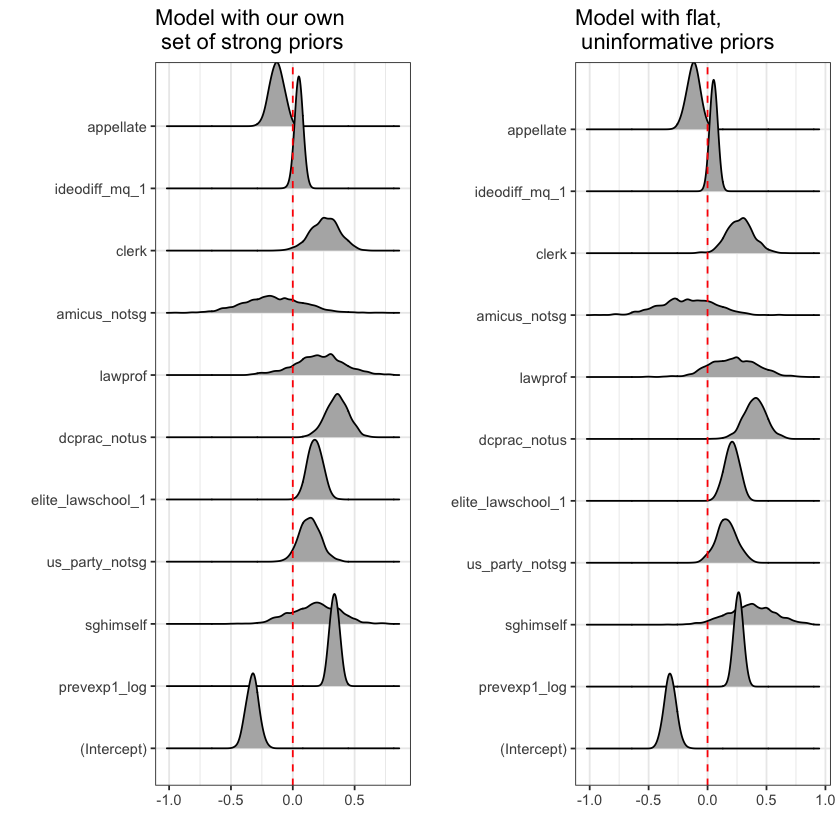

In [19]:
#Let's plot the posterior distributions of the coefficients so that they look nice in an article.
#Compared to the code we've got, i'll add a 0 vertical line, to placate frequentists.
#And, for the variable I'm most interested in, experience, I'll plot the posterior distribution separately
#with 90%, 95% and 99% credible intervals

strong_df <- as.data.frame(lm_mcmc_prior[[1]])
strong_df <- melt(strong_df[,-4])

weak_df <- as.data.frame(lm_mcmc_0[[1]])
weak_df <- melt(weak_df[,-4])


strong_plot <- ggplot()+
  labs(x = "", y = "")+
  geom_density_ridges(aes(strong_df$value, strong_df$variable)) +
    theme_bw() + ggtitle("Model with our own \n set of strong priors") + 
    geom_vline(xintercept = 0, linetype="dashed", 
                color = "red")

weak_plot <- ggplot()+
  labs(x = "", y = "")+
  geom_density_ridges(aes(weak_df$value, weak_df$variable)) +
    theme_bw() + ggtitle("Model with flat, \n uninformative priors") +
    geom_vline(xintercept = 0, linetype="dashed", 
                color = "red")

grid.arrange(strong_plot, weak_plot, ncol=2)

#Interesting, we made our very strong prior shift the model quite a bit - exactly as I wanted.
#And moved the posterior distribution of the"himself" coefficient quite a bit towards zero, now straddling zero quite a bit
#So I guess he coded himself as quite experienced.

In [20]:
paste("My model with very strong prior: ", lm_mcmc_prior$DIC)
paste("Base model with flat prior: ", lm_mcmc_0$DIC)

[1] "My model with very strong prior:  2947.76453562734"

[1] "Base model with flat prior:  2943.08142256002"

The model with my chosen, strong priors exhibits shrinkage from the very strong prior I have set. The posterior mean is substantially shifted to the mean of the prior distribution. The base model, however, is more likely given the data

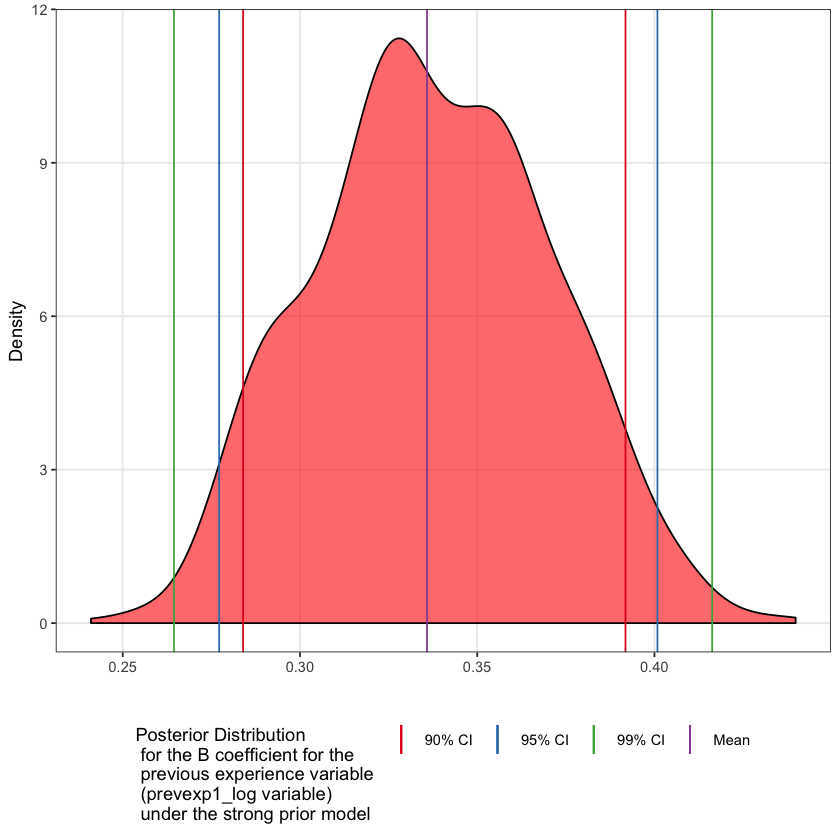

In [22]:
strong_df <- as.data.frame(lm_mcmc_prior[[1]])
#strong_df <- melt(strong_df[,-4])
strong_df <- strong_df['prevexp1_log']


ggplot() +
  labs(x="", y="Density")+
  geom_density(aes(strong_df[,1]), fill="red", alpha=.6)+
  geom_vline(aes(color="Mean", xintercept=(c(quantile(strong_df[,1], .5), quantile(strong_df[,1], .5)))))+
  geom_vline(aes(color="99% CI", xintercept=(c(quantile(strong_df[,1], .005), quantile(strong_df[,1], .995)))))+
  geom_vline(aes(color="95% CI", xintercept=(c(quantile(strong_df[,1], .025), quantile(strong_df[,1], .975)))))+
  geom_vline(aes(color="90% CI", xintercept=(c(quantile(strong_df[,1], .05), quantile(strong_df[,1], .95)))))+
  theme_bw() +  scale_color_manual("Posterior Distribution \n for the B coefficient for the \n previous experience variable \n (prevexp1_log variable)\n under the strong prior model",
                    values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00')) +
  theme(panel.grid.minor.x=element_blank(), panel.grid.minor.y=element_blank(),
        legend.position="bottom")


## Task 1.1. A local sensitivity study using other priors


I'll keep the multivariate normal prior used for the previous exercise, but vary both the mean and the varaince across a few specifications to gauge the effect of the prior.

To make it easier to understand and interpret, I'll set a flat, uninformative prior on everything else except my main beta of interest (prevexp1_log - *previous experience*) on everything else.

I will then run a cross-validation study for my prior - going across 5*5=25 hyperparameters for my model testing all combination for

`
prior_mean=c(-.25,0,0.25,0.5,1)
prior_sd=c(0.1,0.5,1,5,20)
`

In [73]:
#I'll choose 5 prior means and five sd's (using a multivariate normal) for the experience variable.
#For each prior, run a model, and print the posterior mean and the 95% credible interval else.
# mean and credible intervals.
#
#Note that the code below will take some time to run, approximately 5 minutes on my machine, 
#since it estimates 25 different models.

prior=c(-.25,0,0.25,0.5,1)
sd=c(0.1,0.5,1,5,20)
#Everything else is flat, mu = 0, se=1000
mu_prior_rep = rep(0,length(se_prior))
sd_prior_rep = rep(1000,length(se_prior))

result_store = matrix(0, nrow = 25, ncol = 6)

for (i in 1:5) {
    for (j in 1:5) {
        
        #Take the flat multivariate N(0,1000) prior above
        #And for the variable of interest ONLY (vcv[2,2], mu[2]) replace
        #With the prior combinations in the table
        
        #prior mu
        print(paste("i:", i,"j:",j))
        s_mu <- mu_prior_rep
        s_mu[2] = prior[i]
        print(s_mu)
        
        ##prior vcv
        s_vcv <- diag(length(sd_prior_rep))
        diag(s_vcv) <- sd_prior_rep^2
        s_vcv[2,2]=sd[j]^2
        
        paste('Now running model number',i*5+j,' out of 25')
        
        # First column will store the mean of the prior described by i
        result_store[(i-1)*5+j,1]=prior[[i]]
        # Second column will store the sd of the prior described by j
        result_store[(i-1)*5+j,2]=sd[[j]]
        
        # Let's now run the models
        # We won't keep the full model objects in RAM. Should work, I have 16 GB RAM
        # But I won't need them
        sensitivity_pp <- list(B = list(mu = s_mu, V = s_vcv))
        sensitivity_mcmc <- MCMCglmm(jws_formula, data = jws, prior = sensitivity_pp)
        
        #Third column DIC
        result_store[(i-1)*5+j,3] <- sensitivity_mcmc[['DIC']]
        sens_fit_df <- as.data.frame(sensitivity_mcmc[[1]])
        #Fourth column: LEFT 95% CI
        result_store[(i-1)*5+j,4] <- quantile(sens_fit_df$prevexp1_log,.025)[[1]]
        #Fifth column: RIGHT 95% CI
        result_store[(i-1)*5+j,5] <- quantile(sens_fit_df$prevexp1_log,.975)[[1]]
        #Sixth column: MEAN
        result_store[(i-1)*5+j,6]  <- mean(sens_fit_df$prevexp1_log)[[1]]
        }
    }

[1] "i: 1 j: 1"
 [1]  0.00 -0.25  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00

                       MCMC iteration = 0

                       MCMC iteration = 1000

                       MCMC iteration = 2000

                       MCMC iteration = 3000

                       MCMC iteration = 4000

                       MCMC iteration = 5000

                       MCMC iteration = 6000

                       MCMC iteration = 7000

                       MCMC iteration = 8000

                       MCMC iteration = 9000

                       MCMC iteration = 10000

                       MCMC iteration = 11000

                       MCMC iteration = 12000

                       MCMC iteration = 13000
[1] "i: 1 j: 2"
 [1]  0.00 -0.25  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00

                       MCMC iteration = 0

                       MCMC iteration = 1000

                       MCMC iteration = 2000

                       MCMC itera

The following table displays the results of the sensibility test above:

`mu_prior` = mean of the prior distribution for the beta (multivariate normal prior) for the variable of interest (previous experience)

`sd_prior` = standard deviation of the prior distribution for the beta.

`DIC` = DIC for the model trained using the priors above

`b_coef_CI_left` and `b_coef_CI_right` = 95% credible interval of the posterior distributior for the beta coefficient, given the prior

All other priors, for all other betas, kept non-informative (`mu_prior`=0, `sd_prior`=1000). Same likelihood model as in the main replication regression used.

In [74]:
colnames(result_store) <- c("mu_prior","sd_prior","DIC","b_coef_CI_left","b_coef_CI_right","b_coef_mean")
result_store

mu_prior,sd_prior,DIC,b_coef_CI_left,b_coef_CI_right,b_coef_mean
-0.25,0.1,2945.512,0.1496503,0.2729781,0.2100058
-0.25,0.5,2942.940,0.1953227,0.3315564,0.2604796
-0.25,1.0,2943.023,0.1993494,0.3301961,0.2622732
-0.25,5.0,2943.135,0.2005424,0.3310570,0.2638253
-0.25,20.0,2943.195,0.2010184,0.3262313,0.2624150
0.00,0.1,2943.557,0.1715471,0.2993155,0.2336611
0.00,0.5,2943.020,0.2042270,0.3267954,0.2615340
0.00,1.0,2943.228,0.1935464,0.3324557,0.2619140
0.00,5.0,2942.953,0.1974215,0.3325738,0.2624880
0.00,20.0,2943.031,0.1995304,0.3270855,0.2630061


A plot of credible intervals

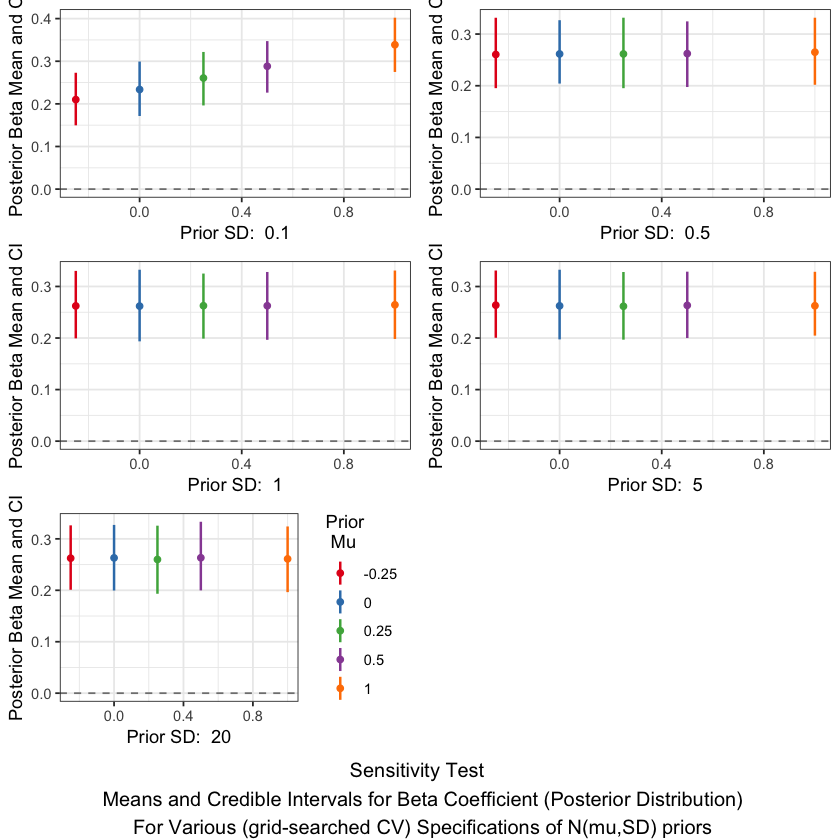

In [82]:
library(rlist)

plotter <- as.data.frame(result_store)
plotter$id <- 1:nrow(plotter)

plot_list <- list()


# Note to self:
# There's a stupid bug in aes. For some reason it is lazily evaluated on print,
# not allowing you to set aes (and this controls the data->graph stuff)
# This means aes will not work with multiple graphs in a loop. aes_string works, per stack_overflow solution

for (subset in sd) {
    #print(subset)
    psub <- plotter%>%filter(sd_prior==subset)
    #print(psub)
    graph <- ggplot() + labs(x=paste("Prior SD: ",subset), y="Posterior Beta Mean and CI")
    graph <- graph + geom_hline(yintercept = 0, colour = gray(1/2), lty = 2)
    graph <- graph + geom_linerange(aes_string(x=psub$mu_prior, 
                                ymin = psub$b_coef_CI_left, 
                                ymax = psub$b_coef_CI_right, 
                                color=as.factor(psub$mu_prior)),
                            lwd = 0.7)
    graph <- graph + geom_point(aes_string(x = psub$mu_prior, 
                                                y = psub$b_coef_mean,
                                                color=as.factor(psub$mu_prior)))
    graph <- graph + theme_bw() + scale_color_manual("Prior \n Mu",
                                                     values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'))
    if (subset!=20) {
        graph<-graph+theme(legend.position = "none") 
        }
    #print(graph)
    #graph
    plot_list = list.append(plot_list,graph)
    }

label_bottom=paste("Sensitivity Test \n", 
                   "Means and Credible Intervals for Beta Coefficient (Posterior Distribution)\n",
                   "For Various (grid-searched CV) Specifications of N(mu,SD) priors")
grid_arrange_closure <- partial(grid.arrange, ncol=2, 
                                bottom=label_bottom)#, title="Se")
do.call(grid_arrange_closure,plot_list)

#grid.newpage()
#grid.draw(legend)


For a normal prior, given the data, the sensitivity test shows stable posterior distributions of the beta coefficient for most priors. Only when we specify very strong priors does this change.

## Task 1.2 Model selection

In [23]:
#Let's reset the seed:
set.seed(27182)

In [24]:
#Eliminate variables that are not to be included in the model . se
jws_bms <- jws%>%dplyr::select(-usid,-docket,-caseid,-term,-lawyernumber)

                          PIP     Post Mean     Post SD Cond.Pos.Sign Idx
prevexp1_log      1.000000000  0.2988577639 0.028689304             1   1
dcprac_notus      0.986000000  0.3625642986 0.099801359             1   6
elite_lawschool_1 0.957000000  0.2209758060 0.075895543             1   5
clerk             0.417666667  0.1195281292 0.159601693             1   9
appellate         0.384666667 -0.0522495261 0.074241260             0  11
ideodiff_mq_1     0.222333333  0.0118794905 0.025278641             1  10
us_party_notsg    0.171666667  0.0287298935 0.072550228             1   4
sghimself         0.086000000  0.0254158090 0.100038192             1   2
casereargued      0.076333333  0.0139488211 0.065233761             1  14
lawprof           0.073666667  0.0152415216 0.078318147             1   7
amicus_notsg      0.051666667 -0.0069069710 0.061313416             0   8
certunan          0.027666667 -0.0008576867 0.015085547             0  15
sg_asst           0.023333333  0.00111

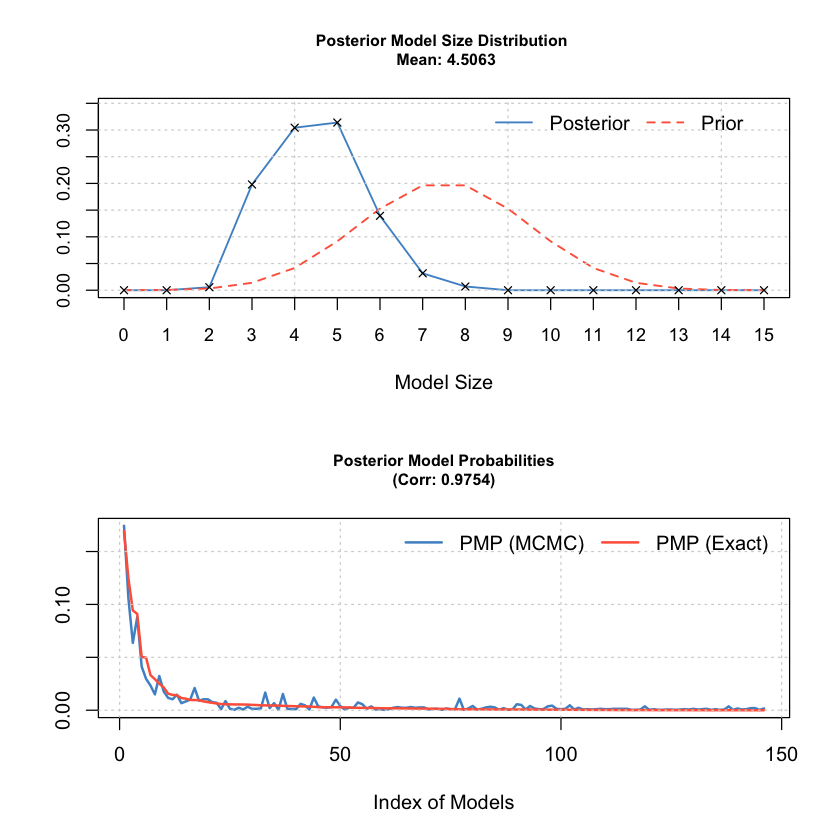

In [33]:
#Run BMS with uniform priors. 
jws_bms_unif <- bms(jws_bms, mprior = "uniform")
#It doesn't use the seed and reseeds each time. Results will not be consistent/run

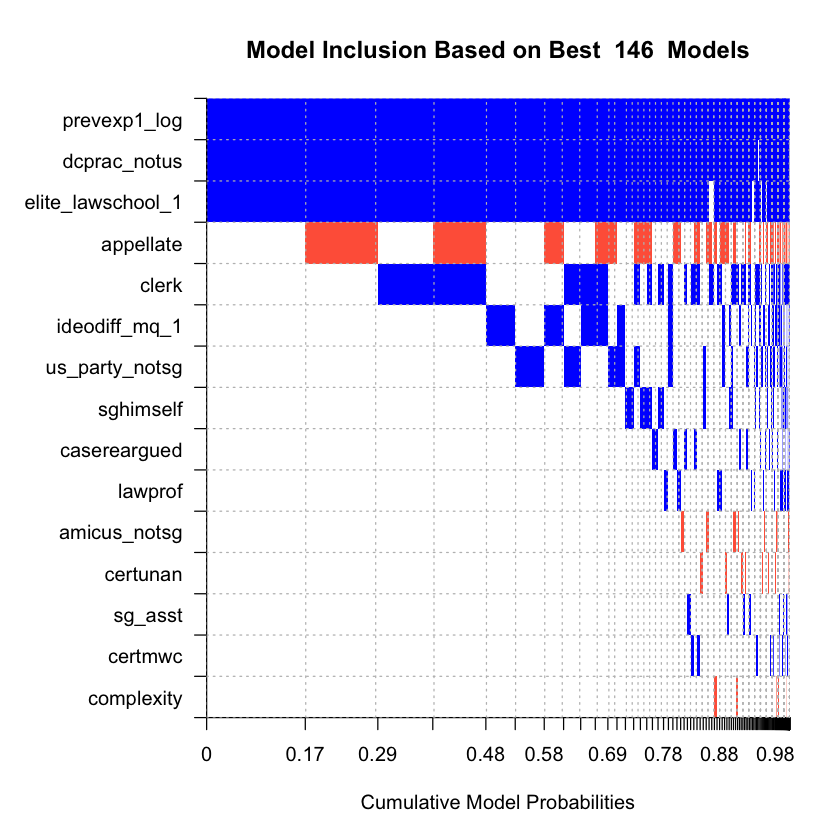

In [34]:
image(jws_bms_unif)

In [35]:
"Cumulative PMP best four models"
sum(topmodels.bma(jws_bms_unif)[ , 1:4]['PMP (MCMC)',])

[1] "Cumulative PMP best four models"

[1] 0.4316667

In [37]:
topmodels.bma(jws_bms_unif)[ , 1:5]

,4600,4610,4640,4650,4620
prevexp1_log,1.0000000,1.0000000,1.00000000,1.00000000,1.00000000
sghimself,0.0000000,0.0000000,0.00000000,0.00000000,0.00000000
sg_asst,0.0000000,0.0000000,0.00000000,0.00000000,0.00000000
us_party_notsg,0.0000000,0.0000000,0.00000000,0.00000000,0.00000000
elite_lawschool_1,1.0000000,1.0000000,1.00000000,1.00000000,1.00000000
dcprac_notus,1.0000000,1.0000000,1.00000000,1.00000000,1.00000000
lawprof,0.0000000,0.0000000,0.00000000,0.00000000,0.00000000
amicus_notsg,0.0000000,0.0000000,0.00000000,0.00000000,0.00000000
clerk,0.0000000,0.0000000,1.00000000,1.00000000,0.00000000
ideodiff_mq_1,0.0000000,0.0000000,0.00000000,0.00000000,1.00000000


In [39]:
PMP_M14 = as.vector(topmodels.bma(jws_bms_unif)[ , 1:4]['PMP (MCMC)',])
PMP_M1 = topmodels.bma(jws_bms_unif)[,1]['PMP (MCMC)'][[1]]

"PMP of Best 4 models:"
PMP_M14

"PMP of Best Model:"
PMP_M1

"Relative PMP:"

PMP_M14/PMP_M1

[1] "PMP of Best 4 models:"

[1] 0.17433333 0.10566667 0.06366667 0.08800000

[1] "PMP of Best Model:"

[1] 0.1743333

[1] "Relative PMP:"

[1] 1.0000000 0.6061185 0.3652008 0.5047801

Under the uniform prior we start with an equal probability distribution for each possible model. This results in a prior mean model size of 15/2=7.5 - thus, under this prior the most probable expected model size is equally either 7 or 8 variables. 

The posterior mean model size is 4.5063, meaning a more parsimonious model is favored - the highest probability mass (median) is on a model of 5 predictors - a more parsimonious model is more probable given the data than the one we expected in the prior. 

Three variables stand out as having an extremely high posterior inclusion probability (PIP) - previous experience (`prevexp1_log`), presence in the Washington elite (`dcprac_notus`) and attendence at an elite lawschool (`elite_lawschool_1`). Previous experience has a posterior inclusion probability of 1 - it is certain to be included as a predictor in a model of quality of oral arguments given this data, all the models rest on this variable. DC elite practice and elite lawschool past attendance have a marginally lower posterior inclusion probability (at a PIP of .986 and respectively .957) - being as well essentially included in (nearly) all models given this data.

In all models tested, the sign of the three variables above is always positive, showing a highly robust relationship - higher previous experience, presence in the Washington elite and attendence at an elite law school will always be good predictors for the grade of the oral arguments - irrespective of the other "control variables". In all three cases, the expected substantive effect is rather big (.29, .36 and respectively .22 for the three variables).

The next variable has a PIP of less than half - `apellate` is only half as probable to be included in a model of the relationship as the three variables above -  and the sign on this variable is negative (in all models where it is included) - we are certain a negative relation is expected. The substantive effect, however, where included, is very low (-.05).

Further, given the preference of parsimonious, explainable models in reseach, the decision to omit `complexity`,
`certmwc`, `casereargued`, and `certunan`, while clearly not principled, was a good chioce - their inclusion in models explaining the data is very improbable (PIPs of 0.02-0.06). However, were the author to use a more principled model selection technique such as bms, given the omission of these variables, and a similar threshold, other controls could have just as well be eliminated, as they have a very similar PIP : `lawprof`,`amicus_notsg` and `sg_asst`, which have an even lower PIP (thus a very low probability of being included in a model), but are given some treatment in the paper.


The five best models have a posterior model probability of .432, with the second model having a .81 probability vs. the model with the highest PMP. The fourth model is only 50.47% as probable as the first model to represent the data given the uniform prior. All four best models are extremely parsimonious. The best model includes solely the three variables with a PIP close to 1 described above, with the remaining 3 including one of `appelate` or `clerk` or both of them (the least best model in these five, given the data and prior is the best model). 

Below, a Bayes factor between a model with only the three main variables and one including appelate and clerk

In [40]:
m1 <- MCMCregress(grade ~ prevexp1_log + dcprac_notus + elite_lawschool_1 + appellate + clerk, data = jws, b0 = rep(0, times = 6), 
                  B0 = rep(.001, times = 6), c0 = 10, d0 = 450000, 
                  marginal.likelihood = "Chib95")
m2 <- MCMCregress(grade ~ prevexp1_log + dcprac_notus + elite_lawschool_1, data = jws, 
                  b0 = rep(0, times = 4), B0 = rep(.001, times = 4), c0 = 10, 
                  d0 = 450000, marginal.likelihood = "Chib95")

BayesFactor(m1, m2)$BF.mat[1,2]  #m1 is numerator; m2 denominator
#BayesFactor(m1, m2)$BF.log.mat
BayesFactor(m1, m2)$BF.mat
### Does this mean evidence AGAINST model 1? Most parsimonious one wins? OK then.
### Using Jefferys rule, evidence is clear towards M1.

[1] 0.003073785

,m1,m2
m1,1.0000,0.003073785
m2,325.3317,1.000000000


# Task 2. Simulation

### a) Select a model:

I chose the most parsimonious model and best performing model (highest Posterior Model Probabilities) in the Bayesian model selection algorithm -- one one hand, given the explored prior space, this model has the highest probability of correctly modeling the data, and on the other han, it only has 3 covariates, making prediction reasonable.

This leads to this formula:

grade ~ prevexp1_log + dcprac_notus + elite_lawschool_1

with flat priors

In [41]:
m2 <- MCMCregress(grade ~ prevexp1_log + dcprac_notus + elite_lawschool_1, data = jws,
                  burnin = 5000, mcmc = 15000,
                  b0 = rep(0.0, times = 4), B0 = rep(0.01, times = 4), marginal.likelihood = "Chib95")

In [42]:
summary(m2)


Iterations = 5001:20000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 15000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                     Mean      SD  Naive SE Time-series SE
(Intercept)       -0.3495 0.03645 0.0002976      0.0002976
prevexp1_log       0.3020 0.02743 0.0002240      0.0002240
dcprac_notus       0.3753 0.08836 0.0007215      0.0007094
elite_lawschool_1  0.2389 0.05970 0.0004874      0.0004763
sigma2             0.8181 0.03473 0.0002835      0.0002835

2. Quantiles for each variable:

                     2.5%     25%     50%     75%   97.5%
(Intercept)       -0.4199 -0.3740 -0.3494 -0.3255 -0.2763
prevexp1_log       0.2478  0.2837  0.3019  0.3203  0.3556
dcprac_notus       0.2006  0.3157  0.3751  0.4351  0.5483
elite_lawschool_1  0.1215  0.1992  0.2389  0.2791  0.3571
sigma2             0.7526  0.7946  0.8172  0.8407  0.8892


### b) Predict Y^ for the model via simulations

In [43]:
# Get model objects
b2_df <- as.data.frame(as.mcmc(m2))
b2_coefs <-  b2_df %>% dplyr::select(-sigma2)
b2_sigma2 <- b2_df %>% dplyr::select(sigma2)

In [44]:
#Add the intercept
jws_intercept <- jws
jws_intercept$intercept <- 1

In [45]:
# Just select the covariates we need.
X <- jws_intercept %>% dplyr::select(intercept, prevexp1_log, dcprac_notus, elite_lawschool_1)
X_tiny <- X[3:6,]

In [85]:
### Simulate from the Posterior Predictive Distribution ###
## Function to draw from the PPD ##
## Derived work from work presented in class ###

ppd <- function(X, post.dist, n.draws = nrow(post.dist), sigma.dist){
  #Returns E[x] - expected values (y_mu == BX)
  #And predicted values P[x] where y_hat ~ N(y_mu,sigma2)
  #This is slightly weird, a the expected value comes from a distribution as well.
  #And so does sigma2.
  #Sigma2 is passed as a separate vector, 1 sigma2 for each separate vector
  X <- as.matrix(X) # Data 
  beta <- as.matrix(post.dist) 
  sigma.dist <- as.matrix(sigma.dist)
  # Posterior distribution of the coefficients
  n <- nrow(X) # Sample size
    
  d <- matrix(NA, nrow = n, ncol = n.draws) # Empty matrix for the loop
  # This loop computes XB for every simulate of the posterior distribution
  for(i in 1:n.draws){
    d[ , i] <- X %*% beta[i, ] #Ith row of beta-->ith column of d
  }
  
  d.pp <- d 
  # creating predicted value
  draws <- matrix(NA, nrow = n, ncol = n.draws) 
  # This loop draws a new value of y given the XB value in d.pp 
  # (for linear models, use rnorm())
  for(j in 1:n.draws){
    if(class(d.pp) == "matrix"){
      draws[ , j] <- rnorm(n = n, mean = d.pp[ , j], sd = sqrt(sigma.dist[[j]]))
    } else
      draws[ , j] <- rnorm(n = n, mean = d.pp[, j], sd = sqrt(sigma.dist[[j]]))
    }
  return(list(e_x = d.pp, p_x = draws)) 
  # The function returns the values of XB and the actual draws of y
}

In [47]:
pred_tiny = ppd(X=X_tiny,
    post.dist=b2_coefs,
    n.draws =5,
    sigma.dist=b2_sigma2)

pred = ppd(X=X,
    post.dist=b2_coefs,
    sigma.dist=b2_sigma2)

In [48]:
print ("Simulated Expected Values - tiny version, just to see all looks well")
pred_tiny$e_x


print("Simulated Predicted Values - tiny version")
pred_tiny$p_x


[1] "Simulated Expected Values - tiny version, just to see all looks well"


-0.3375877,-0.3672557,-0.3281043,-0.2853948,-0.3100200
1.0965216,1.2807515,1.2704702,0.9929205,1.1000758
0.3064119,0.2511225,0.2806674,0.1257707,0.3311073
-0.3375877,-0.3672557,-0.3281043,-0.2853948,-0.3100200


[1] "Simulated Predicted Values - tiny version"


-0.1456663,-1.0805854,-0.1239997,-0.2077691,-0.8940553
-0.8083027,3.2998022,0.8402405,0.2632432,0.9875290
1.3618209,-0.8669301,-0.4988350,-0.8556404,0.4454735
0.3874040,-0.4846179,0.1829004,-0.9209776,-0.4311800


In [49]:
# And let's predict many, many simulations, for all the observations in the dataset.
pred_big = ppd(X=X,
    post.dist=b2_coefs,
    sigma.dist=b2_sigma2)

In [50]:
# Let's see that all is well. We should have 15000 simulations x 1118 observations.
nsim = ncol(pred_big$p_x)
nobs = nrow(pred_big$p_x)
print(paste("NSIM:",nsim," NOBS:",nobs))


[1] "NSIM: 15000  NOBS: 1118"


### c) Let's do the same, but with the authors' original model

In [51]:
model_authors <- MCMCregress(jws_formula, data = jws,
                  burnin = 5000, mcmc = 15000,
                  b0 = rep(0.0, times = 4), B0 = rep(0.01, times = 4), marginal.likelihood = "Chib95")

In [52]:
summary(model_authors)


Iterations = 5001:20000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 15000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                      Mean      SD  Naive SE Time-series SE
(Intercept)       -0.31721 0.04842 0.0003953      0.0003953
prevexp1_log       0.26247 0.03406 0.0002781      0.0002797
sghimself          0.36889 0.19902 0.0016250      0.0016250
sg_asst            0.10180 0.10103 0.0008249      0.0008249
us_party_notsg     0.16635 0.08821 0.0007202      0.0007202
elite_lawschool_1  0.20908 0.06043 0.0004934      0.0004934
dcprac_notus       0.40122 0.09191 0.0007505      0.0007505
lawprof            0.21725 0.21069 0.0017202      0.0017202
amicus_notsg      -0.16457 0.23770 0.0019408      0.0019408
clerk              0.27380 0.11469 0.0009364      0.0009364
ideodiff_mq_1      0.05124 0.02537 0.0002071      0.0002149
appellate         -0.12020 0.05508 0.0004497      0.0004497
sigma2             0.

In [53]:
X_auth <- jws_intercept %>% dplyr::select(intercept,prevexp1_log,sghimself,sg_asst,
                                     us_party_notsg,elite_lawschool_1,dcprac_notus,lawprof,
                                     amicus_notsg, clerk, ideodiff_mq_1, appellate)
                                     
bm_df <- as.data.frame(as.mcmc(model_authors))
bm_coefs <-  bm_df %>% dplyr::select(-sigma2)
bm_sigma2 <- bm_df %>% dplyr::select(sigma2)

pred_big_auth = ppd(X=X_auth,
    post.dist=bm_coefs,
    sigma.dist=bm_sigma2)

In [54]:
nsim = ncol(pred_big_auth$p_x)
nobs = nrow(pred_big_auth$p_x)
print(paste("NSIM:",nsim," NOBS:",nobs))

[1] "NSIM: 15000  NOBS: 1118"


In [55]:
y=jws_intercept%>%dplyr::select(grade)

auth_yh = pred_big_auth$p_x
yh = pred_big$p_x

In [56]:
for (i in 1:15000) {
    yh[,i]=(y[,1]-yh[,i])**2
    auth_yh[,i]=(y[,1]-auth_yh[,i])**2
    }

In [57]:
rmse_yh=rep(0,15000)
rmse_auth_yh=rep(0,15000)
for (i in 1:15000) {
    rmse_yh[[i]]=sqrt(sum(yh[,i])/15000)
    rmse_auth_yh[[i]]=sqrt(sum(auth_yh[,i])/15000)
    }

In [58]:
"RMSE (in sample) for parsimonious, 3 variable model; 15000 sims, MCMC, Bayes, flat priors"
mean(rmse_yh)

[1] "RMSE (in sample) for parsimonious, 3 variable model; 15000 sims, MCMC, Bayes, flat priors"

[1] 0.3489582

In [59]:
"RMSE (in sample) for original, 12 variable model; 15000 sims, MCMC, Bayes, flat priors"
mean(rmse_auth_yh)

[1] "RMSE (in sample) for original, 12 variable model; 15000 sims, MCMC, Bayes, flat priors"

[1] 0.3462879

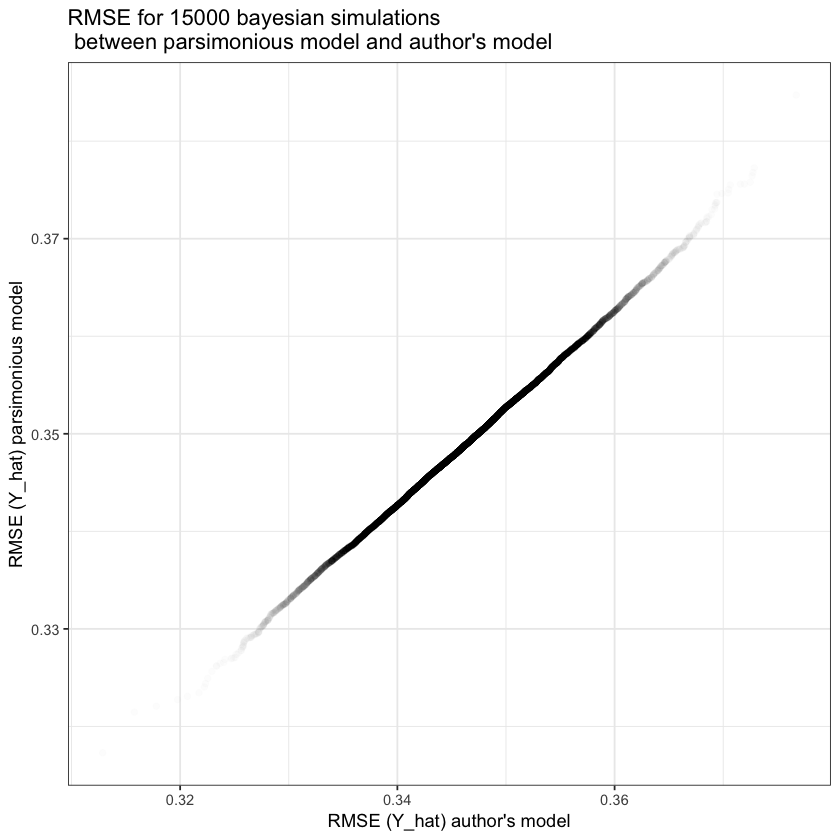

In [70]:
graph <- ggplot() +
geom_point(aes(sort(rmse_auth_yh),sort(rmse_yh)), alpha=0.01) + theme_bw() + 
labs(title="RMSE for 15000 bayesian simulations \n between parsimonious model and author's model", 
     y="RMSE (Y_hat) parsimonious model", x="RMSE (Y_hat) author's model")
graph

Essentially **NO** difference in in-sample predictive power between a model with 3 variables and the one with 12 that the authors used.